# 1. Datasets Requirement before Phenotyping
## 1.1 Find all admission items having Scan Records
### Neuroimaging/Vascularimaging
* DWI MRI / MRA: Gold standard in Neuroimaging.
* CT Scan: More available, maybe larger cohort, but not sensitive to early ischemic changes.
* Plus CTA: Angiography helps guide treatments, often preferred in emergency stroke settings

## 1.2 Or admission items by clinical phenotypes
### 1.2.1 Clinical Assessment
* NIHSS (National Institutes of Health Stroke Scale): Gold standard, assessment of consciousness, motor function, sensory function and language ability.
* Start from Large Vessel Occulusions (LOVs)

### 1.2.2 Stroke Risk Factors (Comorbidity)
* High blood pressure (typically > 180 mmHg)
* Atrial fibrillation
* cholesterol levels
* hyperlipidemia
* diabetes

## **Supporting Literature**:
* 'Diagnostic accuracy of clinical tools for assessment of acute stroke: a systematic review' https://bmcemergmed.biomedcentral.com/articles/10.1186/s12873-019-0262-1
* 'Comparative analysis, applications, and interpretation of electronic health record-based stroke phenotyping methods'
https://biodatamining.biomedcentral.com/articles/10.1186/s13040-020-00230-x

# 2. Cohort Extract Coding
## 2.1 Phenotyping by ICD-9 codes of stroke & NIHSS Clinical assessment
### 2.1.1 NIHSS Score
* Table: `chartevents`
* Itemid for NIHSS score: Search for this based on clinical charting of NIHSS scores or documented neurological exams in clinical notes.
* Criteria: Use NIHSS ≥ 6 to identify patients likely to have LVOs.

### 2.1.2 Clinical Notes of vital signs
* Table: `chartevents`
* Criteria: Use Natural Language Processing (NLP) to search for terms related to *aphasia*, *neglect*, and *hemiparesis* etc. in the clinical notes, particularly in discharge summaries or neurological exams.

## 2.2 Lab Results for Stroke Risk Factors (Weak)
* Table: `lab_event`
* **LDL cholesterol (50931)** and **HDL cholesterol (50924)** are markers of atherosclerosis.
**Blood glucose (50809)** and HbA1c levels are useful for identifying diabetic patients at higher stroke risk.

## 2.3 Diagnostics of Risk Factors (For features)
* Table: `diagnostic_icd`
* Criteria: ICD-10 codes like I48.0 for *Atrial fibrillation*, G45.9 for TIA, I10 for Hypertension, E11 for Type2 Diabetes and E78 for Hyperlipidemia.

## Environment setting and libraries import
* Install libraries required for BigQuery and data accessing

In [1]:
import pandas as pd
from pandas_gbq import read_gbq
import os
from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
client = bigquery.Client(location="US")

* Link to my Google Service Account key so that the MIMIC database can be accessed via
BigQuery.

* By using Google Colab, the account can be easily authenciated by auth module.

## Query function for BigQuery
* Get ready for accessing data via query API
* Set the parameters required for BigQuery

In [3]:
# Set up environment variables
project_id = 'comp90089-440404'

# Read data from BigQuery into pandas dataframes
def run_query(query, project_id=project_id):
    return read_gbq(
        query,
        project_id=project_id,
        dialect='standard'
    )

## Extracting Stroke Patients in ICU

This SQL code identifies a group of patients who have been diagnosed with a stroke and were also admitted to the ICU. It specifically targets patients with ICD-9 codes related to stroke (433 and 434) and matches their records to ICU admissions, providing a list of these patients sorted by their unique identifiers.

In [4]:
# SQL cod for extracting patients with all criterion
query_isp=f"""
WITH stroke_patients AS (
  SELECT di.subject_id, di.hadm_id
  FROM physionet-data.mimiciv_hosp.diagnoses_icd di
  WHERE di.icd_version = 9 AND (di.icd_code LIKE '433%' OR di.icd_code LIKE '434%')
),

icu_stroke_patients AS (
  SELECT DISTINCT sp.subject_id, sp.hadm_id
  FROM stroke_patients sp
  JOIN `physionet-data.mimiciv_icu.icustays` AS icustays
    ON sp.subject_id = icustays.subject_id
    AND sp.hadm_id = icustays.hadm_id
)

SELECT subject_id, hadm_id
FROM icu_stroke_patients
ORDER BY subject_id, hadm_id
"""

In [5]:
# Execute the query and fetch results
df_isp = run_query(query_isp)

# Display results
print(df_isp.shape)

Downloading: 100%|██████████|
(2193, 2)


# 3. Feature Extracting
15 features from the following 5 aspects are considered:
* Demographics (**Age**, **Gender**, **Weight**, **Height**, **Infection**, **LoS**, **Admission**)
* ICU Vital Signs (**BP**, **Heart Rate**, **Temperature**, **Respiratory Rate** )
* Infections (**WBC Count**, **CRP Level**)
* Lab Cardiovascular Tests (**CK-MB Component**, **Troponin T Level**)
* Comorbidities (**Hypertension**, **Diabetes**, **Astrial Fibrillation**, **Charlson Index**)

In [6]:
# subject_id and admission_id lists
subject_ids = list(df_isp['subject_id'].unique())
cohort_subject_ids = "[" + ", ".join(str(id) for id in subject_ids) + "]"

hadm_ids=list(df_isp['hadm_id'].unique())
cohort_hadm_ids = "[" + ", ".join(str(id) for id in hadm_ids) + "]"

## 3.1 Demographics

## Extracting Age and Gender for ICU Stroke Patients

This retrieves age and gender details for ICU stroke patients, identified by `subject_ids`.


In [7]:
query_gender_age=f"""
WITH dmg_age AS (
SELECT subject_id, anchor_age AS age
FROM physionet-data.mimiciv_hosp.patients
WHERE subject_id IN UNNEST ({cohort_subject_ids})
),

dmg_gender AS (
SELECT subject_id, gender
FROM physionet-data.mimiciv_hosp.patients
WHERE subject_id IN UNNEST ({cohort_subject_ids})
)

SELECT dmg_age.subject_id, dmg_age.age, dmg_gender.gender
FROM dmg_age
LEFT JOIN dmg_gender ON dmg_age.subject_id = dmg_gender.subject_id
ORDER BY dmg_age.subject_id
"""

In [8]:
df_gender_age = run_query(query_gender_age)
df_isp_cohort=df_isp.merge(df_gender_age, on='subject_id', how='left')

Downloading: 100%|██████████|


### Demographics-2: Weight and Height (average)

* Itemid for Weight (Kg) in table `chartevents`: (226512(Admission Weight), 224639(Daily Weight))
* Itemid for Height (cm) in table `chartevents`:226730

In [9]:
query_wtht=f"""
WITH
dmg_weight AS (
SELECT ie.hadm_id,
  AVG(ce.valuenum) AS weight
FROM ({query_isp}) ie
-- admission weight
LEFT JOIN`physionet-data.mimiciv_icu.chartevents` As ce
  ON ie.hadm_id = ce.hadm_id AND itemid IN (226512, 224639)
WHERE ce.valuenum IS NOT NULL
GROUP BY ie.hadm_id
),

dmg_height AS (
SELECT  isp.hadm_id,
  MAX(ce.valuenum) AS height
FROM ({query_isp}) isp
-- admission height
LEFT JOIN`physionet-data.mimiciv_icu.chartevents` As ce
  ON isp.hadm_id = ce.hadm_id AND itemid = 226730
WHERE ce.valuenum IS NOT NULL
GROUP BY isp.hadm_id
)

SELECT dmg_weight.hadm_id, dmg_weight.weight, dmg_height.height
FROM dmg_weight
LEFT JOIN dmg_height ON dmg_weight.hadm_id = dmg_height.hadm_id
ORDER BY dmg_weight.hadm_id
"""

In [10]:
df_wtht = run_query(query_wtht)
df_isp_cohort=df_isp_cohort.merge(df_wtht, on='hadm_id', how='left')

Downloading: 100%|██████████|


### ICU Stay
* Length of Stay (sum_los)
* ICU Stay Counts (n_stays)

In [11]:
query_los=f"""
SELECT
  icustays.hadm_id As hadm_id,
  count(icustays.stay_id) As n_stays,
  sum(icustays.los) As sum_los
FROM
`physionet-data.mimiciv_icu.icustays` AS icustays
WHERE
  subject_id IN UNNEST ({cohort_subject_ids}) AND
  hadm_id IN UNNEST ({cohort_hadm_ids})
GROUP BY
 	hadm_id
ORDER BY
  hadm_id
"""

In [12]:
df_los = run_query(query_los)
df_isp_cohort=df_isp_cohort.merge(df_los, on='hadm_id', how='left')

Downloading: 100%|██████████|


## 3.2 ICU Vital Signs

### **ICU Vital Signs (Statistics)**
**References**:
* https://intjem.biomedcentral.com/articles/10.1186/1865-1380-5-3
* https://neurolrespract.biomedcentral.com/articles/10.1186/s42466-023-00238-8

In [13]:
query_vs = f"""

WITH vs_sbp AS (
SELECT hadm_id, MAX(valuenum) AS sbp_max
FROM physionet-data.mimiciv_icu.chartevents
WHERE hadm_id IN UNNEST ({cohort_hadm_ids}) AND
itemid IN (
SELECT itemid
FROM physionet-data.mimiciv_icu.d_items
WHERE label LIKE '%Arterial Blood Pressure%'
) AND valueuom IN ("mmHg")
GROUP BY hadm_id
),

vs_hr AS (
SELECT hadm_id, AVG(valuenum) AS heart_rate_avg
FROM physionet-data.mimiciv_icu.chartevents
WHERE hadm_id IN UNNEST ({cohort_hadm_ids}) AND
itemid IN (
SELECT itemid
FROM physionet-data.mimiciv_icu.d_items
WHERE label LIKE '%Heart Rate%'
) AND valueuom IN ("bpm") 
GROUP BY hadm_id
ORDER BY hadm_id
),

vs_rr AS (
SELECT  hadm_id, AVG(valuenum) AS respiratory_rate_avg
FROM physionet-data.mimiciv_icu.chartevents
WHERE hadm_id IN UNNEST ({cohort_hadm_ids}) AND
itemid IN (
SELECT itemid
FROM physionet-data.mimiciv_icu.d_items
WHERE label LIKE '%Respiratory Rate%'
) AND valueuom IN ("insp/min") 
GROUP BY hadm_id
ORDER BY  hadm_id
),

vs_tmp AS(
SELECT hadm_id, MAX(valuenum) AS rec_temperature_max_F
FROM physionet-data.mimiciv_icu.chartevents
WHERE hadm_id IN UNNEST ({cohort_hadm_ids}) AND
itemid IN (
SELECT itemid
FROM physionet-data.mimiciv_icu.d_items
WHERE label LIKE '%Temperature Fahrenheit%'
) AND valueuom IN ("°F")
GROUP BY hadm_id
ORDER BY hadm_id
)

SELECT vs_rr.hadm_id, vs_tmp.rec_temperature_max_F, vs_sbp.sbp_max, vs_hr.heart_rate_avg, vs_rr.respiratory_rate_avg
FROM vs_rr
LEFT JOIN vs_tmp ON vs_tmp.hadm_id = vs_rr.hadm_id
LEFT JOIN vs_sbp ON vs_tmp.hadm_id = vs_sbp.hadm_id
LEFT JOIN vs_hr ON vs_tmp.hadm_id = vs_hr.hadm_id
ORDER BY vs_rr.hadm_id

"""

In [14]:
df_vs = run_query(query_vs)
df_isp_cohort=df_isp_cohort.merge(df_vs, on='hadm_id', how='left')

Downloading: 100%|██████████|


## 3.3 Inflammatory Infections

### **Infections Biomarkers**

### WBC MAX (White Blood Cell Counts)
* Biomarker WBC counts consider all WBC lab test records for lacking number of a single WBC bomarker
* This biomarker might not be sufficient for the cohort

In [15]:
query_wbc = f"""
SELECT le.hadm_id, MAX(le.valuenum) AS wbc_max
FROM physionet-data.mimiciv_hosp.labevents AS le
JOIN physionet-data.mimiciv_hosp.d_labitems AS dl
ON le.itemid = dl.itemid
WHERE le.hadm_id IN UNNEST ({cohort_hadm_ids})
AND LOWER(dl.label) LIKE '%wbc%'
AND le.valueuom IN ("#/hpf")
AND LOWER(dl.fluid) LIKE '%urine%'
GROUP BY le.hadm_id
HAVING wbc_max IS NOT NULL
ORDER BY le.hadm_id;
"""

In [16]:
df_wbc = run_query(query_wbc)
df_isp_cohort=df_isp_cohort.merge(df_wbc, on='hadm_id', how='left')

Downloading: 100%|██████████|


In [17]:
query_lymphocyte = f"""
SELECT le.hadm_id, AVG(le.valuenum) AS lymphocyte_percentage
FROM physionet-data.mimiciv_hosp.labevents AS le
JOIN physionet-data.mimiciv_hosp.d_labitems AS dl
ON le.itemid = dl.itemid
WHERE le.hadm_id IN UNNEST({cohort_hadm_ids}) 
    AND LOWER(dl.label) LIKE '%lymphocyte%'
    AND le.valueuom IN ("%")
    AND LOWER(dl.fluid) LIKE '%blood%'
GROUP BY le.hadm_id
HAVING lymphocyte_percentage IS NOT NULL
ORDER BY le.hadm_id;
"""

In [18]:
df_lymphocyte = run_query(query_lymphocyte)
df_isp_cohort=df_isp_cohort.merge(df_lymphocyte, on='hadm_id', how='left')

Downloading: 100%|██████████|


### RBC MAX (Red Blood Cell Counts)

In [19]:
query_rbc = f"""
SELECT  le.hadm_id, MAX(le.valuenum) as rbc_max
FROM physionet-data.mimiciv_hosp.labevents AS le
JOIN physionet-data.mimiciv_hosp.d_labitems AS dl
ON le.itemid = dl.itemid
WHERE le.hadm_id IN UNNEST ({cohort_hadm_ids}) 
AND LOWER(dl.label) LIKE '%rbc%'
AND LOWER(dl.fluid) LIKE '%urine%'
AND le.valueuom IN ("#/hpf")
GROUP BY le.hadm_id
HAVING rbc_max IS NOT NULL
ORDER BY le.hadm_id;
"""

In [20]:
df_rbc = run_query(query_rbc)
df_isp_cohort=df_isp_cohort.merge(df_rbc, on='hadm_id', how='left')

Downloading: 100%|██████████|


### CRP Levels (C-Reactive Protein)
* This biomarker records might be limited in terms of our cohort
* Substitution could be **Fibrinogen**, **Lactate**, **Albumin**
* Albumin and Fibrinogen might involve multiple subtypes of tests
**References**: https://doi.org/10.5853/jos.2018.02369

In [21]:
query_lactate = f"""
SELECT le.hadm_id, MAX(le.valuenum) AS lactate_level_max
FROM physionet-data.mimiciv_hosp.labevents AS le
JOIN physionet-data.mimiciv_hosp.d_labitems AS dl
ON le.itemid = dl.itemid
WHERE le.hadm_id IN UNNEST ({cohort_hadm_ids})
AND LOWER(dl.label) LIKE '%lactate%'
AND LOWER(dl.fluid) LIKE '%blood%'
AND le.valueuom IN ("mmol/L")
GROUP BY le.hadm_id
HAVING lactate_level_max IS NOT NULL
ORDER BY le.hadm_id;
"""

In [22]:
df_lactate = run_query(query_lactate)
df_isp_cohort=df_isp_cohort.merge(df_lactate, on='hadm_id', how='left')

Downloading: 100%|██████████|


In [23]:
query_alb = f"""
SELECT le.hadm_id, MIN(le.valuenum) AS alb_level_min
FROM physionet-data.mimiciv_hosp.labevents AS le
JOIN physionet-data.mimiciv_hosp.d_labitems AS dl
ON le.itemid = dl.itemid
WHERE le.hadm_id IN UNNEST ({cohort_hadm_ids})
AND LOWER(dl.label) LIKE '%albumin%'
AND LOWER(dl.fluid) LIKE '%blood%'
AND le.valueuom IN ("g/dL")
GROUP BY le.hadm_id
HAVING alb_level_min IS NOT NULL
ORDER BY le.hadm_id;
"""

In [24]:
df_alb = run_query(query_alb)
df_isp_cohort=df_isp_cohort.merge(df_alb, on='hadm_id', how='left')

Downloading: 100%|██████████|


## 3.4 Lab Test Results

### Tropoin T Levels

In [25]:
query_trt = f"""
SELECT le.hadm_id, MAX(le.valuenum) AS trt_max
FROM physionet-data.mimiciv_hosp.labevents AS le
JOIN physionet-data.mimiciv_hosp.d_labitems AS dl
ON le.itemid = dl.itemid
WHERE le.hadm_id IN UNNEST ({cohort_hadm_ids})
AND LOWER(dl.label) LIKE '%troponin t%'
AND LOWER(dl.fluid) LIKE '%blood%'
AND le.valueuom IN ("ng/mL")
GROUP BY le.hadm_id
HAVING trt_max IS NOT NULL
ORDER BY le.hadm_id;
"""

In [26]:
df_trt = run_query(query_trt)
df_isp_cohort=df_isp_cohort.merge(df_trt, on='hadm_id', how='left')

Downloading: 100%|██████████|


### Glucose Level (Hyperglycemia)
* Use count of abnormal glucose test results (very high or very low).

In [27]:
query_glucose = f"""
SELECT le.hadm_id,
       (SUM(CASE WHEN le.valuenum > 180 THEN 1 ELSE 0 END) + 
        SUM(CASE WHEN le.valuenum < 70 THEN 1 ELSE 0 END)) AS glucose_extreme_count
FROM physionet-data.mimiciv_hosp.labevents AS le
JOIN physionet-data.mimiciv_hosp.d_labitems AS dl
ON le.itemid = dl.itemid
WHERE le.hadm_id IN UNNEST({cohort_hadm_ids})
AND LOWER(dl.label) LIKE '%glucose%'
AND LOWER(dl.fluid) LIKE '%blood%'
AND le.valueuom IN ("mg/dL")
GROUP BY le.hadm_id
HAVING glucose_extreme_count IS NOT NULL
ORDER BY le.hadm_id;
"""

In [28]:
# Run the query to get the glucose data
df_glucose = run_query(query_glucose)
df_isp_cohort=df_isp_cohort.merge(df_glucose, on='hadm_id', how='left')

Downloading: 100%|██████████|


### Sodium Level (Hypernatremia)
* Same statistic with Glucose

In [29]:
query_sodium = f"""
SELECT le.hadm_id, 
       (SUM(CASE WHEN le.valuenum > 145 THEN 1 ELSE 0 END) + 
        SUM(CASE WHEN le.valuenum < 135 THEN 1 ELSE 0 END)) AS sodium_extreme_count
FROM physionet-data.mimiciv_hosp.labevents AS le
JOIN physionet-data.mimiciv_hosp.d_labitems AS dl
ON le.itemid = dl.itemid
WHERE le.hadm_id IN UNNEST({cohort_hadm_ids})
AND LOWER(dl.label) LIKE '%sodium%'
AND LOWER(dl.fluid) LIKE '%blood%'
AND le.valueuom IN ("mEq/L") 
GROUP BY le.hadm_id
HAVING sodium_extreme_count IS NOT NULL
ORDER BY le.hadm_id;
"""

In [30]:
# Run the query to get the sodium data
df_sodium = run_query(query_sodium)
df_isp_cohort=df_isp_cohort.merge(df_sodium, on='hadm_id', how='left')

Downloading: 100%|██████████|


## 3.5 Comorbidities

In [31]:
query_hpt = f"""
SELECT hadm_id,
CASE WHEN COUNT(icd_code) > 0 THEN 1 ELSE 0 END AS has_hypertension
FROM physionet-data.mimiciv_hosp.diagnoses_icd
WHERE hadm_id IN UNNEST ({cohort_hadm_ids}) AND
icd_code IN (
SELECT icd_code
FROM physionet-data.mimiciv_hosp.d_icd_diagnoses
WHERE LOWER(long_title) LIKE '%hypertension%'
)
GROUP BY  hadm_id
ORDER BY  hadm_id
"""

In [32]:
df_hpt = run_query(query_hpt)
df_isp_cohort=df_isp_cohort.merge(df_hpt, on='hadm_id', how='left')
df_isp_cohort['has_hypertension'] = df_isp_cohort['has_hypertension'].fillna(0).astype(int)

Downloading: 100%|██████████|


In [33]:
query_dbt = f"""
SELECT hadm_id,
CASE WHEN COUNT(icd_code) > 0 THEN 1 ELSE 0 END AS has_diabetes
FROM physionet-data.mimiciv_hosp.diagnoses_icd
WHERE hadm_id IN UNNEST ({cohort_hadm_ids}) AND
icd_code IN (
SELECT icd_code
FROM physionet-data.mimiciv_hosp.d_icd_diagnoses
WHERE LOWER(long_title) LIKE '%diabetes%' OR LOWER(long_title) LIKE '%type 2 diabetes%'
)
GROUP BY  hadm_id
ORDER BY  hadm_id
"""

In [34]:
df_dbt = run_query(query_dbt)
df_isp_cohort=df_isp_cohort.merge(df_dbt, on='hadm_id', how='left')
df_isp_cohort['has_diabetes'] = df_isp_cohort['has_diabetes'].fillna(0).astype(int)

Downloading: 100%|██████████|


### Atrial Fibrillation

In [35]:
query_af = f"""
SELECT hadm_id,
CASE WHEN COUNT(icd_code) > 0 THEN 1 ELSE 0 END AS has_af
FROM physionet-data.mimiciv_hosp.diagnoses_icd
WHERE hadm_id IN UNNEST ({cohort_hadm_ids}) AND
icd_code IN (
SELECT icd_code
FROM physionet-data.mimiciv_hosp.d_icd_diagnoses
WHERE LOWER(long_title) LIKE '%atrial fibrillation%' OR LOWER(long_title) LIKE '%atrial flutter%'
)
GROUP BY  hadm_id
ORDER BY  hadm_id
"""

In [36]:
df_af = run_query(query_af)
df_isp_cohort=df_isp_cohort.merge(df_af, on='hadm_id', how='left')
df_isp_cohort['has_af'] = df_isp_cohort['has_af'].fillna(0).astype(int)

Downloading: 100%|██████████|


### Comorbidity Score
* charlson_comorbidity_index

In [37]:
query_cs = f"""
WITH
comorbidity_weights AS (
    SELECT 'I10' AS icd_code, 1 AS weight  -- Hypertension
    UNION ALL
    SELECT 'I21', 1  -- Myocardial Infarction (ICD-10)
    UNION ALL
    SELECT '410', 1  -- Myocardial Infarction (ICD-9)
    UNION ALL
    SELECT 'I50', 2  -- Congestive Heart Failure (ICD-10)
    UNION ALL
    SELECT '428', 2  -- Congestive Heart Failure (ICD-9)
    UNION ALL
    SELECT 'E10', 1  -- Diabetes without complications (ICD-10)
    UNION ALL
    SELECT '250', 1  -- Diabetes without complications (ICD-9)
    UNION ALL
    SELECT 'E11', 2  -- Diabetes with complications (ICD-10)
    UNION ALL
    SELECT 'N18', 2  -- Chronic Kidney Disease (ICD-10)
    UNION ALL
    SELECT '585', 2  -- Chronic Kidney Disease (ICD-9)
    UNION ALL
    SELECT 'C34', 2  -- Malignant Neoplasm of Lung (ICD-10)
    UNION ALL
    SELECT '162', 2  -- Malignant Neoplasm of Lung (ICD-9)
    UNION ALL
    SELECT 'B20', 6  -- HIV/AIDS
    UNION ALL
    SELECT 'I25', 1  -- Coronary Artery Disease (ICD-10)
    UNION ALL
    SELECT '414', 1  -- Coronary Artery Disease (ICD-9)
    UNION ALL
    SELECT 'K70', 3  -- Liver Disease (ICD-10)
    UNION ALL
    SELECT 'K74', 3  -- Liver Disease (ICD-10)
    UNION ALL
    SELECT 'J44', 1  -- COPD (ICD-10)
    UNION ALL
    SELECT '496', 1  -- COPD (ICD-9)
    UNION ALL
    SELECT 'C50', 2  -- Malignant Neoplasm of Breast (ICD-10)
    UNION ALL
    SELECT '174', 2  -- Malignant Neoplasm of Breast (ICD-9)
    UNION ALL
    SELECT 'F01', 3  -- Dementia (ICD-10)
    UNION ALL
    SELECT 'F03', 3  -- Dementia (ICD-10)
    UNION ALL
    SELECT 'I48', 1  -- Atrial Fibrillation (ICD-10)
)

-- Calculate Charlson Comorbidity Index for each patient in the cohort
SELECT
       di.hadm_id,
       SUM(COALESCE(cw.weight, 0)) AS charlson_comorbidity_index
FROM physionet-data.mimiciv_hosp.diagnoses_icd di
LEFT JOIN comorbidity_weights cw
    ON di.icd_code = cw.icd_code
WHERE hadm_id IN UNNEST ({cohort_hadm_ids})
GROUP BY di.hadm_id
ORDER BY di.hadm_id;

"""

In [38]:
df_cs = run_query(query_cs)
df_isp_cohort=df_isp_cohort.merge(df_cs, on='hadm_id', how='left')

Downloading: 100%|██████████|


In [39]:
dataX=df_isp_cohort.copy()

## 3.6 Admission Type

### **Unique admission: Records with readmission**
* Treat each hadm_id as an indivdual (a sample), we get 6581 records stored in *full_cohort*, 1944 out of which get readmitted.

In [40]:
query_sp = f"""
WITH stroke_patients AS (
  SELECT DISTINCT di.subject_id, di.hadm_id
  FROM physionet-data.mimiciv_hosp.diagnoses_icd di
  WHERE di.icd_version = 9 
    AND (di.icd_code LIKE '433%' OR di.icd_code LIKE '434%')
)

SELECT sp.subject_id, sp.hadm_id
FROM stroke_patients sp
ORDER BY sp.subject_id, sp.hadm_id
"""

In [41]:
df_sp=run_query(query_sp)

Downloading: 100%|██████████|


In [42]:
# subject_id and admission_id lists
sp_subject_ids = list(df_sp['subject_id'].unique())
sp_cohort_subject_ids = "[" + ", ".join(str(id) for id in sp_subject_ids) + "]"
#print(len(subject_ids))

sp_hadm_ids=list(df_sp['hadm_id'].unique())
sp_cohort_hadm_ids = "[" + ", ".join(str(id) for id in sp_hadm_ids) + "]"

In [43]:
query_date=f"""
SELECT
    subject_id,
    hadm_id,
    admittime
FROM physionet-data.mimiciv_hosp.admissions
WHERE hadm_id IN UNNEST ({sp_cohort_hadm_ids});
"""

In [44]:
df_isp_date=run_query(query_date)

Downloading: 100%|██████████|


In [45]:
df_isp_date['admittime'] = pd.to_datetime(df_isp_date['admittime'])

merged_df = dataX.merge(df_isp_date, 
                        on=['subject_id', 'hadm_id'], 
                        how='left')

merged_df['discharge_date'] = merged_df['admittime'] + pd.to_timedelta(merged_df['sum_los'], unit='D')

readmissions = merged_df.merge(
    df_isp_date,
    on='subject_id',
    suffixes=('', '_next')
)

readmissions = readmissions[
    (readmissions['hadm_id'] != readmissions['hadm_id_next']) &
    (readmissions['admittime_next'] > readmissions['discharge_date']) &
    (readmissions['admittime_next'] <= readmissions['discharge_date'] + pd.Timedelta(days=365))
]

edaRead = readmissions.copy()

readmissions = readmissions[['subject_id', 'hadm_id']]

In [46]:
class1 = dataX.merge(readmissions[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')
class1['has_readmission'] = 1  # Set has_readmission to 1

In [47]:
no_readmission_subject_ids = df_sp['subject_id'].value_counts()[lambda x: x == 1].index
filtered_dataX_no_readmission = dataX[dataX['subject_id'].isin(no_readmission_subject_ids)]

In [48]:
filtered_dataX_no_readmission = filtered_dataX_no_readmission.copy()

# Calculate the number of null values in each row
filtered_dataX_no_readmission['null_count'] = filtered_dataX_no_readmission.isnull().sum(axis=1)

# Sort the DataFrame by 'null_count' in ascending order
df_least_nulls = filtered_dataX_no_readmission.sort_values(by='null_count')#.head(891)

# Drop the 'null_count' column if no longer needed
df_least_nulls = df_least_nulls.drop(columns=['null_count'])

# Create a copy for class0 and set 'has_readmission' to 0
class0 = df_least_nulls.copy()
class0['has_readmission'] = 0  # Set has_readmission to 0


In [49]:
data = pd.concat([class1, class0], ignore_index=True)

In [50]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_info_columns', 1000)

# 4 Exploratory Data Analysis (EDA)

In [51]:
df = data.copy()
df = df.drop(['subject_id', 'hadm_id'], axis=1)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         2016 non-null   Int64  
 1   gender                      2016 non-null   object 
 2   weight                      2016 non-null   float64
 3   height                      1130 non-null   float64
 4   n_stays                     2016 non-null   Int64  
 5   sum_los                     2016 non-null   float64
 6   rec_temperature_max_F       1995 non-null   float64
 7   sbp_max                     1130 non-null   float64
 8   heart_rate_avg              1995 non-null   float64
 9   respiratory_rate_avg        2016 non-null   float64
 10  wbc_max                     939 non-null    float64
 11  lymphocyte_percentage       1056 non-null   float64
 12  rbc_max                     934 non-null    float64
 13  lactate_level_max           1219 

1. **Stroke Patients**: 
   SQL filters stroke patients using ICD-9 codes (433%, 434%) from the `diagnoses_icd` table. These patients are then matched with ICU stays to include only those admitted to the ICU.

2. **Demographics**:
   SQL extracts **`age`** and **`gender`** from the `patients` table. These demographic features are key predictors of patient outcomes and are merged by `subject_id`.
   - **`weight`** and **`height`**: These features represent the patient's body metrics, with missing values for height likely reflecting difficulty in measuring critically ill patients. Weight data is complete.

3. **Vital Signs**:
   - **`rec_temperature_max_F`**: Maximum temperature during the ICU stay to highlight fever.
   - **`sbp_max`**: Maximum systolic blood pressure reflects the most critical condition.
   - **`heart_rate_avg`** and **`respiratory_rate_avg`**: Average values provide a balanced view of the patient's overall vital signs during the stay.

4. **Inflammatory Infections**:
   - **`wbc_count`**: Latest white blood cell count represents immune system status.
   - **`rbc_count`**: Maximum RBC count per `hadm_id` reflects the worst case for oxygen-carrying capacity.
   - **`lymphocyte_percentage`**: Captures immune system functionality; missing data could indicate testing variability.
   - **`lactate_level_max`**: Reflects metabolic stress, with higher values indicating poor oxygenation or shock.
   - **`alb_level_min`**: Minimum albumin level is an indicator of nutritional and liver function.

5. **Lab Results**:
   - **`trt_max`**: Maximum treatment duration, though this column has significant missing data.
   - **`glucose_extreme_count`** and **`sodium_extreme_count`**: Count the number of times glucose and sodium levels reached extreme values, reflecting metabolic imbalances or critical changes in the patient's condition.

6. **Comorbidities**:
   Binary flags for conditions like hypertension, diabetes, and atrial fibrillation:
   - **`has_hypertension`**, **`has_diabetes`**, and **`has_af`**: Represent major pre-existing conditions that influence patient outcomes.
   - **`charlson_comorbidity_index`**: Summarizes the overall burden of comorbidities, which is a crucial predictor of mortality and complications.

7. **Outcome Variables**:
   - **`has_readmission`**: Flags whether the patient was readmitted within a year of discharge, a key target variable for predicting hospital readmissions.

7. **Miscellaneous Variables**:
   - **`n_stays`**: Counts the number of ICU stays during the hospital admission, showing the complexity or severity of the case.   
   - **`sum_los`**: The total length of stay in the hospital, an essential metric for healthcare resource utilization and outcomes.

- **Non-null counts**: Columns like `weight`, `age`, and comorbidity indicators have no missing data. However, **height**, **sbp_max**, **wbc_count**, **rbc_count**, **trt_max**, and other lab values have missing entries.


In [53]:
df.describe()

,age,weight,height,n_stays,sum_los,rec_temperature_max_F,sbp_max,heart_rate_avg,respiratory_rate_avg,wbc_max,lymphocyte_percentage,rbc_max,lactate_level_max,alb_level_min,trt_max,glucose_extreme_count,sodium_extreme_count,has_hypertension,has_diabetes,has_af,charlson_comorbidity_index,has_readmission
count,2016.0,2016.000000,1130.000000,2016.0,2016.000000,1995.000000,1130.000000,1995.000000,2016.000000,939.000000,1056.000000,934.000000,1219.000000,1155.000000,722.000000,1998.0,2000.0,2016.000000,2016.000000,2016.000000,2016.0,2016.000000
mean,69.221726,81.160839,168.344425,1.138393,5.454389,100.367769,913.974336,80.204275,18.889359,25.773163,13.522087,44.989293,2.936833,3.174892,0.831898,2.504004,4.79,0.584325,0.334821,0.381448,0.09871,0.109623
std,14.94735,23.850315,13.931538,0.42291,7.184710,19.825850,8135.289317,30.651287,3.209989,54.213849,8.671148,108.975006,2.618454,0.697378,2.337998,5.122606,9.027217,0.492960,0.472045,0.485863,0.298347,0.312497
min,19.0,1.000000,0.000000,1.0,0.090417,35.600000,-12.000000,42.750000,8.558621,0.000000,0.000000,0.000000,0.600000,1.000000,0.010000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,60.0,66.375000,160.000000,1.0,1.397772,98.800000,160.000000,71.269353,16.616824,3.000000,7.200000,2.000000,1.500000,2.700000,0.040000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
50%,71.0,78.225000,168.000000,1.0,2.808617,99.600000,177.000000,79.156250,18.555556,8.000000,11.737500,8.000000,2.100000,3.200000,0.130000,0.0,1.0,1.000000,0.000000,0.000000,0.0,0.000000
75%,81.0,92.516667,178.000000,1.0,6.485868,101.000000,201.750000,87.634552,20.946528,24.500000,17.600000,41.000000,3.300000,3.700000,0.597500,3.0,6.0,1.000000,1.000000,1.000000,0.0,0.000000
max,91.0,510.000000,244.000000,5.0,66.584236,978.000000,110160.000000,1313.326531,35.327586,809.000000,62.200000,967.000000,21.000000,4.900000,23.500000,63.0,115.0,1.000000,1.000000,1.000000,1.0,1.000000


**Demographics**

- **Age**: The average age of patients is **69.22 years**, with most patients being elderly (50% are above **71 years**). Ages range from **19 to 91 years**.
- **Weight**: The average weight is **81.16 kg**. There's significant variability, with a range from **1 kg** (likely an error) to **510 kg** (outlier). The median weight is **78.23 kg**.
- **Height**: Only **1130** patients have recorded height data, averaging **168.34 cm**. There are data quality issues, with a minimum value of **0 cm** and a maximum of **244 cm**.

**ICU Stays and Length of Stay**

- **Number of ICU Stays**: Most patients had only **1 ICU stay** (average of **1.14 stays**), with a maximum of **5 stays**.
- **Length of Stay**: The average length of stay is **5.45 days**, but this varies widely (from **0.09 days** to **66.58 days**), indicating that some patients require prolonged care.

**Vital Signs**

- **Temperature**: The average maximum recorded temperature is **100.37°F**, with extreme outliers like **978°F**, indicating data entry errors.
- **Systolic Blood Pressure (SBP)**: The average maximum SBP is **913.97 mmHg**, with an unrealistic range from **-12 mmHg** to **110,160 mmHg**, suggesting significant data quality issues.
- **Heart Rate**: The average heart rate is **80.20 bpm**, but it includes extreme values up to **1313 bpm**, indicating possible outliers.
- **Respiratory Rate**: The average respiratory rate is **18.89 breaths per minute**, which is within normal adult values, though some outliers exist (maximum **35.33 bpm**).

**Lab Results**

- **White Blood Cell (WBC) Count**: The average WBC count is **25.77 k/uL**, with a wide range from **0 to 809**, reflecting significant variability in patient conditions.
- **Lymphocyte Percentage**: Averages at **13.52%**, but ranges from **0% to 62.2%**, indicating potential data entry errors or unique cases.
- **Red Blood Cell (RBC) Count**: The mean RBC count is **44.99 cells/HPF**, with an extreme maximum of **967 cells/HPF**, suggesting outliers.
- **Lactate Level Max**: The average maximum lactate level is **2.94 mmol/L**, with extreme values up to **21.0 mmol/L**, indicating critically ill patients.
- **Albumin Level Min**: The minimum albumin level averaged **3.17 g/dL**, with values as low as **1.0 g/dL**, suggesting possible malnutrition or liver issues.
- **Glucose and Sodium Extremes**: Patients experienced a range of **glucose** and **sodium** extreme counts, with a mean of **2.50 glucose extreme counts** and **4.79 sodium extreme counts**, which may indicate metabolic instability or chronic conditions requiring careful monitoring.

**Comorbidities and Outcomes**

- **Hypertension**: **58.4%** of the patients had hypertension, making it the most common comorbidity in this ICU sample.
- **Diabetes**: **33.5%** of patients were diabetic.
- **Atrial Fibrillation (AF)**: **38.1%** of patients had AF, suggesting a significant cardiac disease burden in this population.
- **Charlson Comorbidity Index**: The average Charlson index score is **0.10**, showing a relatively low comorbidity burden across patients, though the maximum score is **1**.
- **Readmissions**: Only **10.96%** of patients were readmitted within one year, indicating a relatively low readmission rate despite the high prevalence of chronic conditions like hypertension and diabetes.

**Data Quality Issues and Outliers**

- The dataset contains extreme outliers, especially in **vital signs** (e.g., temperature and blood pressure) and **lab results** (e.g., WBC, lactate, RBC counts), indicating possible data entry errors.
- The **minimum values** for some attributes (e.g., **height, weight, and blood pressure**) are **0 or negative**, which likely represent missing data or errors.


## 4.1 Data Cleaning

In [54]:
binary_columns = ['has_hypertension', 'has_diabetes', 'has_af', 'has_readmission']
data[binary_columns] = data[binary_columns].astype(int)

extreme_count_columns = ['glucose_extreme_count', 'sodium_extreme_count']
data[extreme_count_columns] = data[extreme_count_columns].fillna(0).astype(int)

### Outliers Handling
* Statistical Outliers Removing
* Non-Physiologic Outliers Removing

In [55]:
physiological_bounds = {
    'heart_rate_avg': (30, 220),  # Heart rate (bpm)
    'respiratory_rate_avg': (5, 60),  # Respiratory rate (breaths per minute)
    'sbp_max': (50, 300),  # Systolic blood pressure (mmHg)
    'weight': (30, 200),  # Weight (kg) - adjust as needed based on the population
    'height': (100, 250),  # Height (cm) - adjust as needed based on the population
    'rec_temperature_max_F': (93.0, 108.0),  # Temperature (Fahrenheit)
    'wbc_max': (0.0, 100.0),  # White blood cell count (cells per HPF), normal ~0-5, extreme cases allowed
    'rbc_max': (0.0, 100.0),  # Red blood cell count (cells per HPF), normal ~0-3, with extremes
    'lactate_level_max': (0.5, 20.0),  # Lactate (mmol/L), normal ~0.5-2.2, extreme for critical conditions
    'alb_level_min': (1.5, 5.5),  # Albumin (g/dL), normal ~3.5-5.0, with lower bound for critically low
    'trt_max': (0.0, 100.0),  # Troponin T (ng/L), highly variable, >0.01 indicates myocardial injury
    'lymphocyte_percentage': (0.0, 100.0)   # Lymphocyte percentage; adjust based on dataset range
}

# Non-physiologic outliers handling
for col, (min_val, max_val) in physiological_bounds.items():
    if col in data.columns:
        data[col] = data[col].where((data[col] >= min_val) & (data[col] <= max_val), np.nan)  # Set outliers to NaN


In [56]:
df = data.copy()
df = df.drop(['subject_id', 'hadm_id'], axis=1)

In [57]:
df.describe()

,age,weight,height,n_stays,sum_los,rec_temperature_max_F,sbp_max,heart_rate_avg,respiratory_rate_avg,wbc_max,lymphocyte_percentage,rbc_max,lactate_level_max,alb_level_min,trt_max,glucose_extreme_count,sodium_extreme_count,has_hypertension,has_diabetes,has_af,charlson_comorbidity_index,has_readmission
count,2016.0,2008.000000,1126.000000,2016.0,2016.000000,1992.000000,1032.000000,1993.000000,2016.000000,877.000000,1056.000000,818.000000,1216.000000,1145.000000,722.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.0,2016.000000
mean,69.221726,80.746028,168.825222,1.138393,5.454389,99.991516,180.723837,79.471395,18.889359,15.531357,13.522087,16.473105,2.893010,3.191878,0.831898,2.481647,4.751984,0.584325,0.334821,0.381448,0.09871,0.109623
std,14.94735,20.651705,11.203901,0.42291,7.184710,1.590966,33.556564,12.270889,3.209989,21.002565,8.671148,22.749875,2.468199,0.676022,2.337998,5.105114,9.001351,0.492960,0.472045,0.485863,0.298347,0.312497
min,19.0,35.000000,109.000000,1.0,0.090417,94.000000,88.000000,42.750000,8.558621,0.000000,0.000000,0.000000,0.600000,1.500000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,60.0,66.400000,160.000000,1.0,1.397772,98.800000,160.000000,71.256410,16.616824,2.000000,7.200000,2.000000,1.500000,2.700000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,71.0,78.212500,168.000000,1.0,2.808617,99.600000,173.000000,79.147059,18.555556,7.000000,11.737500,6.000000,2.100000,3.200000,0.130000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000
75%,81.0,92.412500,178.000000,1.0,6.485868,101.000000,195.000000,87.596859,20.946528,19.000000,17.600000,22.000000,3.300000,3.700000,0.597500,2.000000,6.000000,1.000000,1.000000,1.000000,0.0,0.000000
max,91.0,195.483333,244.000000,5.0,66.584236,107.000000,300.000000,158.146163,35.327586,98.000000,62.200000,99.000000,18.600000,4.900000,23.500000,63.000000,115.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [58]:
missing_percentage = round((df.isnull().sum() / len(df)) * 100)
missing_percentage = missing_percentage[missing_percentage > 1]
print(missing_percentage)

height                   44.0
sbp_max                  49.0
wbc_max                  56.0
lymphocyte_percentage    48.0
rbc_max                  59.0
lactate_level_max        40.0
alb_level_min            43.0
trt_max                  64.0
dtype: float64


## 4.2 Univariate Analysis

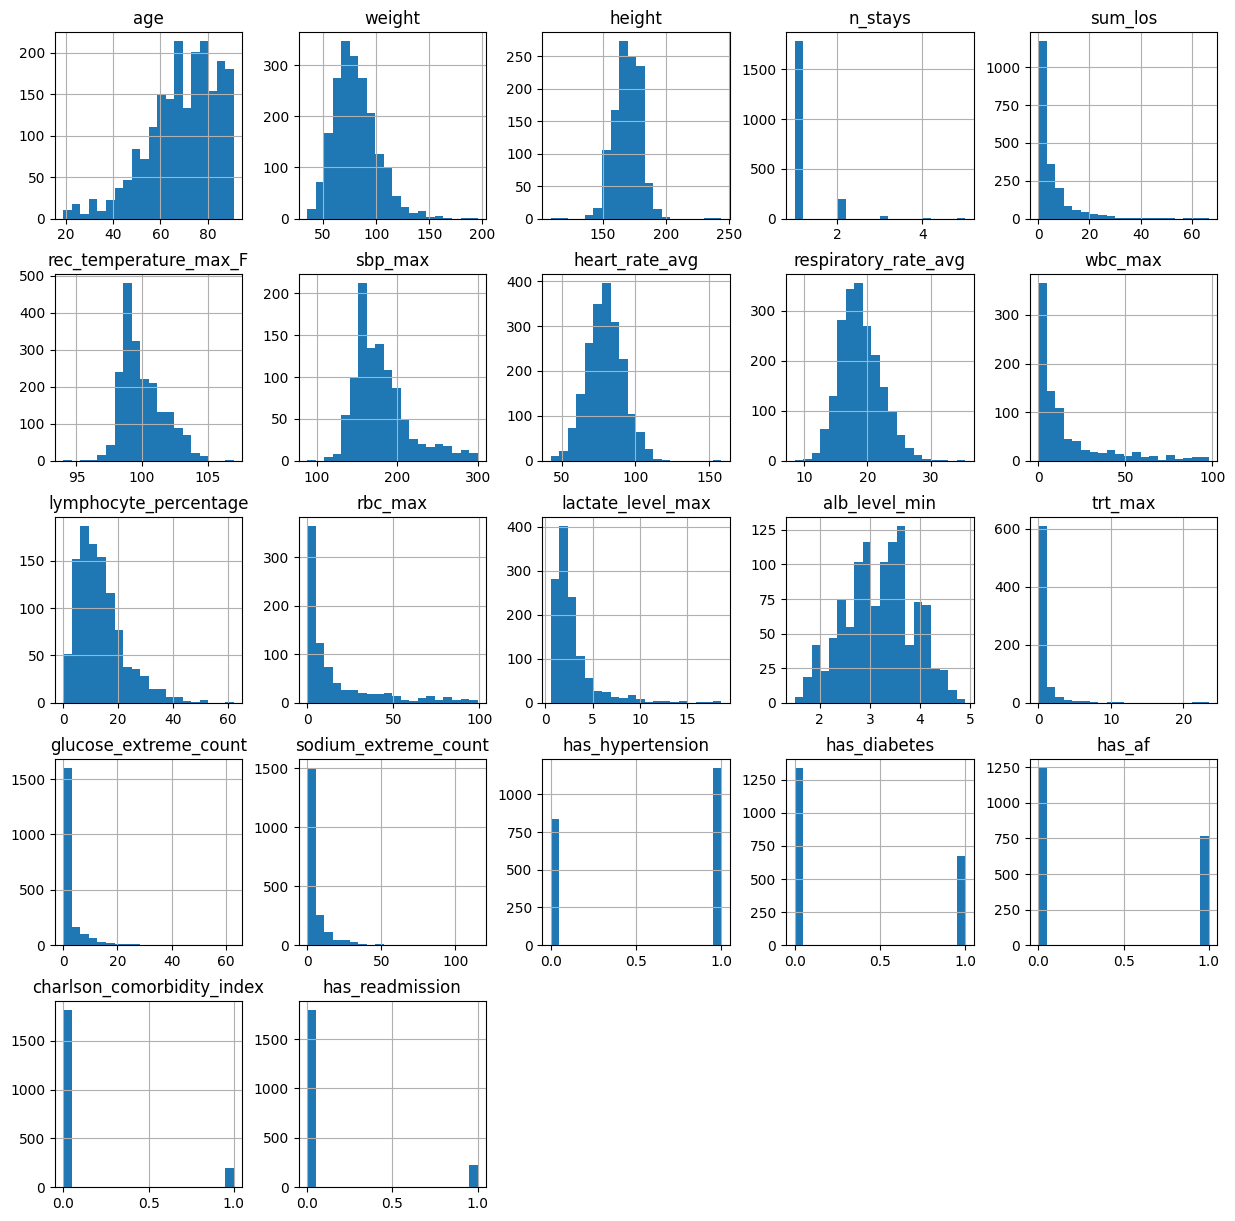

In [59]:
numerical_cols = df.select_dtypes(include=['float64', 'Int64']).columns
df[numerical_cols].hist(bins=20, figsize=(15, 15))
plt.show()


- **Age**: Predominantly elderly patients (60+), highlighting age as a key risk factor for ICU stroke admissions.

- **Weight and Height**: Average weight around 70-80 kg; height data shows missing values, typical for critically ill patients.

- **ICU Stays and Length of Stay**: Most patients have a single ICU stay with short durations, though some cases require extended care.

- **Vital Signs**: 
   - **Temperature**: Peaks around normal, with a few febrile cases suggesting infection.
   - **Blood Pressure**: High systolic values in many patients indicate hypertension.
   - **Heart and Respiratory Rates**: Generally stable, suggesting controlled vital function in most cases.

- **Inflammatory Markers**:
   - **WBC**: Elevated in a few cases, likely indicating infection.
   - **Lymphocytes**: Lower levels in many, hinting at immune suppression.

- **Metabolic and Nutritional Markers**: 
   - **Lactate**: Low in most, with a few elevated cases indicating metabolic stress.
   - **Albumin**: Normal range, though lower levels may suggest malnutrition.

- **Comorbidities**: High prevalence of hypertension and diabetes, common in stroke patients and complicating outcomes.

- **Readmission**: Significant readmission rates within a year, underscoring the need for post-discharge care in this high-risk group.

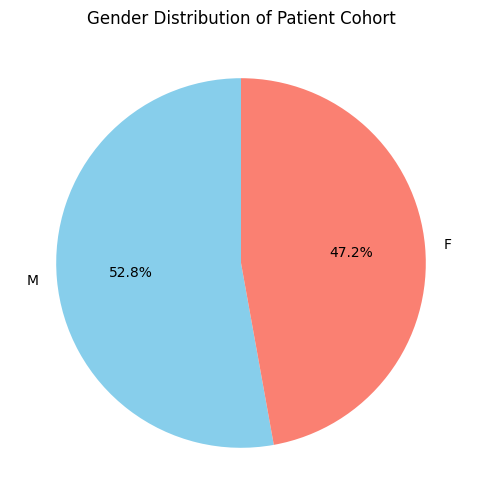

In [60]:
unique_subjects = data.drop_duplicates(subset=['subject_id'])
gender_counts = unique_subjects['gender'].value_counts()
plt.figure(figsize=(6, 6))
gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Gender Distribution of Patient Cohort')
plt.ylabel('')  # Removes the default y-label
plt.show()

- A total of **1,032 male** and **921 female** stroke patients were admitted to the ICU, indicating a slightly higher prevalence of ICU admissions among males in this cohort.

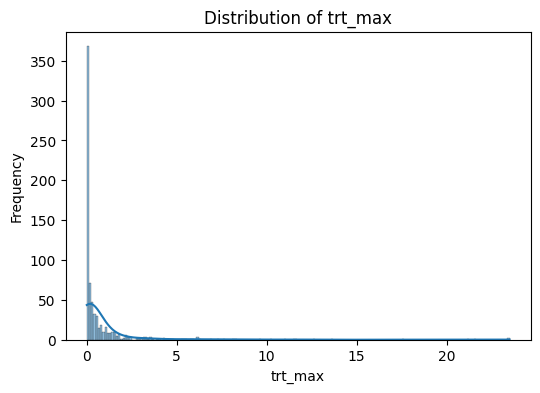

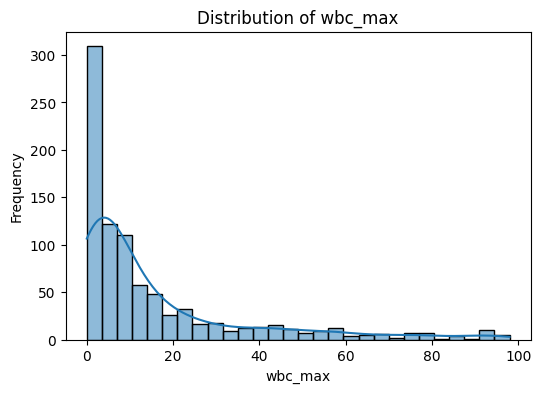

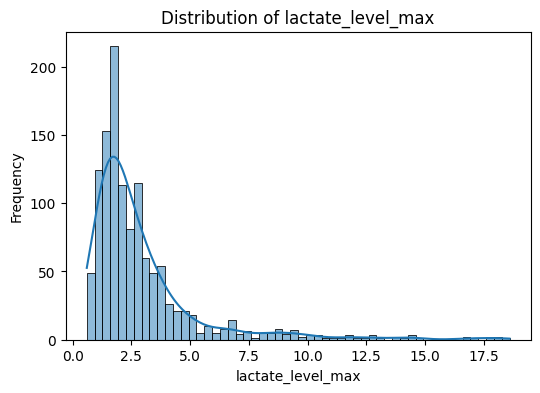

In [61]:
key_metrics = ['trt_max', 'wbc_max', 'lactate_level_max']

for metric in key_metrics:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[metric].dropna(), kde=True)
    plt.title(f"Distribution of {metric}")
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.show()

- **trt_max (Troponin T Levels)**: The distribution is highly left-skewed, showing that most patients have low Troponin T levels, typical for a population without widespread severe cardiac injury. High levels, though less common, indicate severe cardiac stress or damage in a subset of patients.

- **wbc_max (Max White Blood Cell Count)**: Predominantly low with a peak slightly above normal, suggesting mild infections or inflammatory responses are common.

- **lactate_level_max (Max Lactate Levels)**: Mostly low but with a tail extending to higher values, indicating that while severe metabolic or hypoxic stress is less frequent, it occurs in a notable minority of patients.

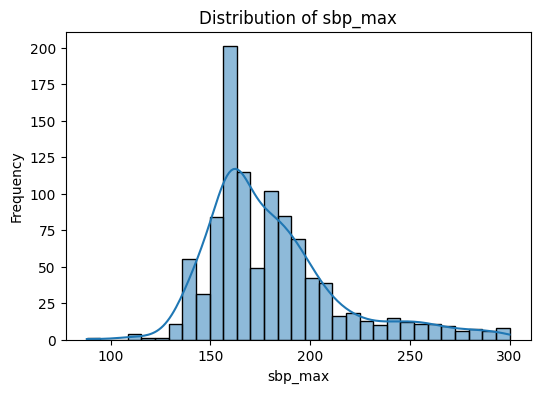

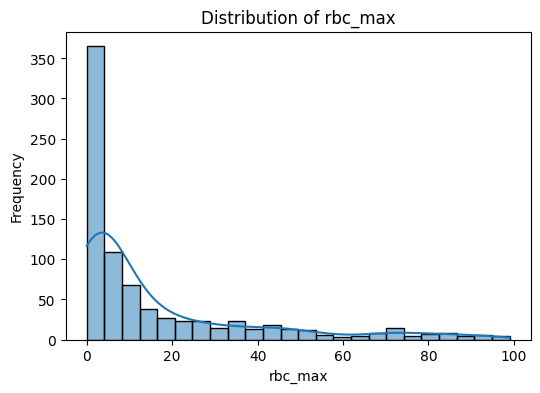

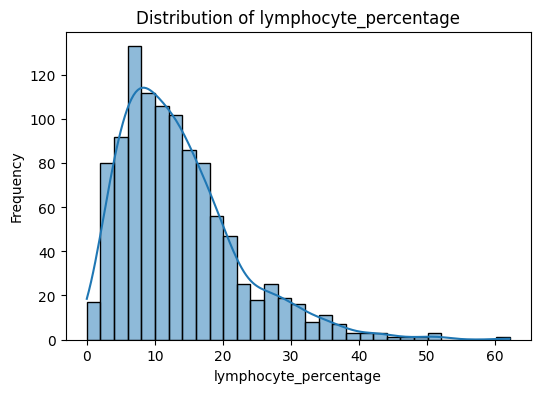

In [62]:
key_metrics = ['sbp_max', 'rbc_max', 'lymphocyte_percentage']

for metric in key_metrics:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[metric].dropna(), kde=True)
    plt.title(f"Distribution of {metric}")
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.show()

- **sbp_max (Maximum Systolic Blood Pressure)**: The distribution peaks around 150 mmHg, with a long tail extending to higher values, suggesting that while many patients have controlled blood pressure, a subset experiences severe hypertension.

- **rbc_max (Maximum Red Blood Cell Count)**: Highly skewed to the left, with most values low. High RBC counts are rare, indicating that extreme RBC levels are uncommon in this patient population.

- **lymphocyte_percentage**: Peaks around 10-15%, with a left-skewed distribution. Lower lymphocyte percentages are more common, possibly reflecting immune suppression or infection.

## 4.3 Bivariate Analysis

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         2016 non-null   Int64  
 1   gender                      2016 non-null   object 
 2   weight                      2008 non-null   float64
 3   height                      1126 non-null   float64
 4   n_stays                     2016 non-null   Int64  
 5   sum_los                     2016 non-null   float64
 6   rec_temperature_max_F       1992 non-null   float64
 7   sbp_max                     1032 non-null   float64
 8   heart_rate_avg              1993 non-null   float64
 9   respiratory_rate_avg        2016 non-null   float64
 10  wbc_max                     877 non-null    float64
 11  lymphocyte_percentage       1056 non-null   float64
 12  rbc_max                     818 non-null    float64
 13  lactate_level_max           1216 

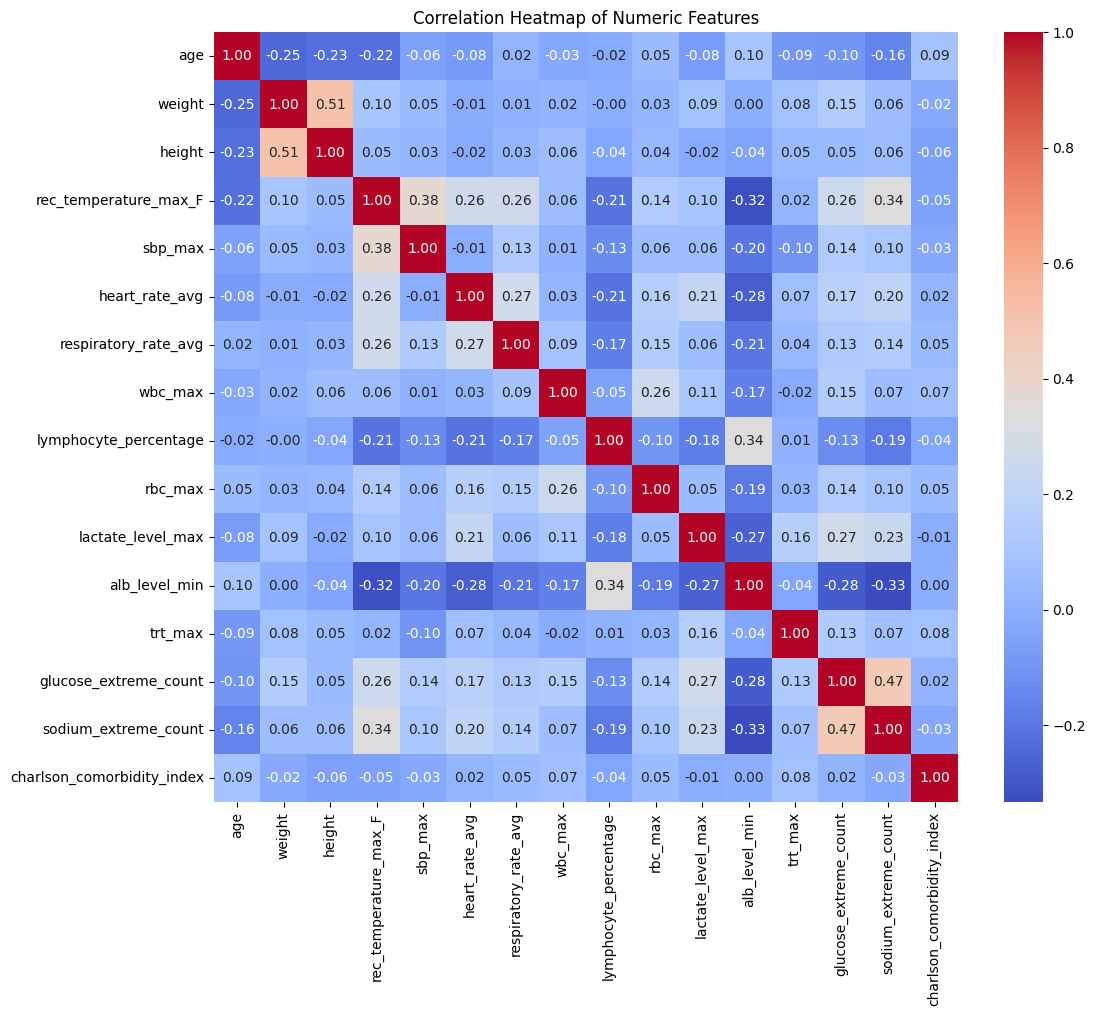

In [64]:
numeric_df = df[['age', 'weight', 'height', 'rec_temperature_max_F', 'sbp_max', 
                 'heart_rate_avg', 'respiratory_rate_avg', 'wbc_max', 'lymphocyte_percentage', 
                 'rbc_max', 'lactate_level_max', 'alb_level_min', 'trt_max', 'glucose_extreme_count', 
                 'sodium_extreme_count', 'charlson_comorbidity_index']]
# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

- **Age** negatively correlates with **height** and **weight**, indicating that younger ICU stroke patients tend to be taller and heavier.

- **Weight** and **height** are positively correlated, reflecting a typical body metric relationship where taller individuals are heavier.

- **Heart Rate** and **Respiratory Rate** correlate moderately, suggesting that increases in one often accompany increases in the other.

- **Lactate Levels** and **Albumin Levels** correlate negatively, indicating that patients with higher lactate (a stress marker) often have lower albumin (a nutritional marker).

- **Glucose** and **Sodium Extremes** show a significant positive correlation, highlighting that patients with unstable glucose levels often experience sodium imbalances as well.


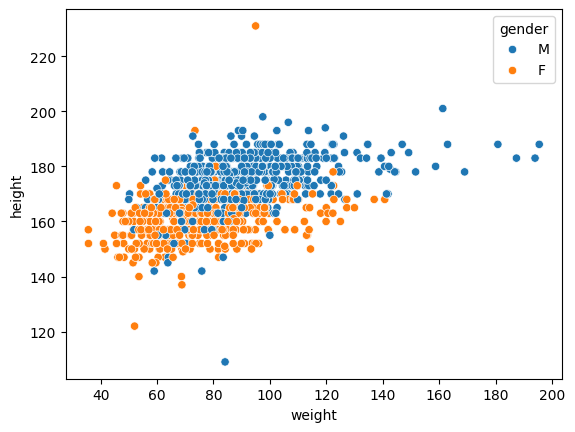

In [65]:
sns.scatterplot(data=df, x='weight', y='height', hue='gender')
plt.show()

- Generally, there's a positive trend indicating that as weight increases, height tends to increase as well.
- Males (blue points) typically have a wider range of weights and heights compared to females (orange points), and there are several heavier and taller males than females.
- The distribution suggests that males are generally taller and possibly heavier than females in this dataset.

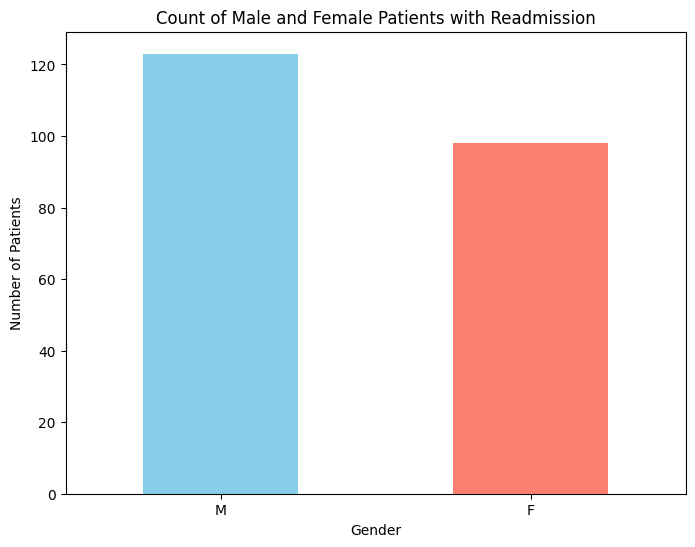

In [66]:
gender_readmission_count = df[df['has_readmission'] == 1]['gender'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(8, 6))
gender_readmission_count.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Count of Male and Female Patients with Readmission")
plt.xlabel("Gender")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.show()

| Gender | Count | Percentage |
|--------|-------|------------|
| Male   | 123   | 55.7%      |
| Female | 98    | 44.3%      |

The table shows that a higher proportion of readmitted patients are male (55.7%) compared to female (44.3%). This indicates that male patients may have a slightly higher likelihood of readmission in this dataset.

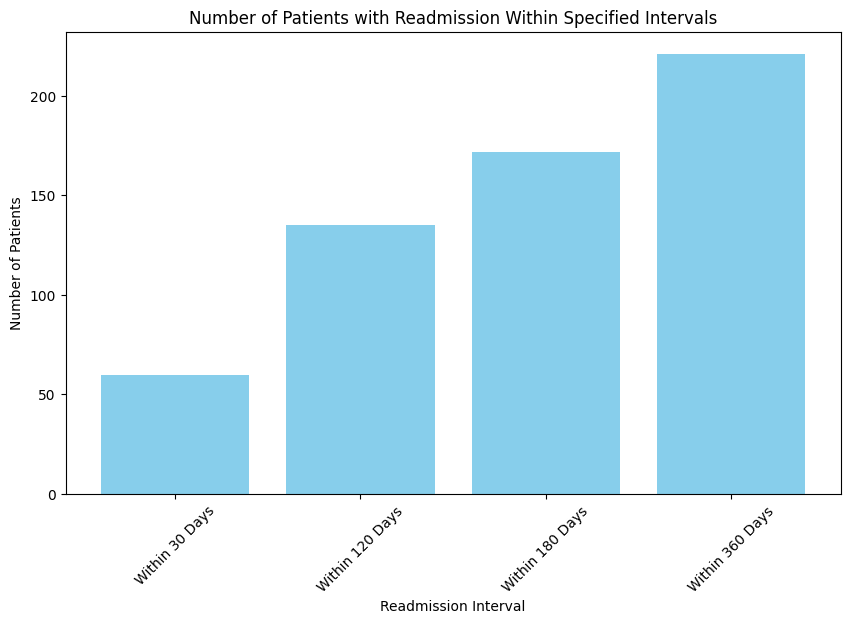

In [ ]:
# Calculate readmission intervals
edaRead['readmission_days'] = (edaRead['admittime_next'] - edaRead['discharge_date']).dt.days

# Define intervals and count readmissions within each interval
intervals = [30, 120, 180, 360]
readmission_counts = {f'Within {days} Days': (edaRead['readmission_days'] <= days).sum() for days in intervals}

# Convert the counts to a DataFrame for easier plotting
readmission_counts_df = pd.DataFrame(list(readmission_counts.items()), columns=['Interval', 'Count'])

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(readmission_counts_df['Interval'], readmission_counts_df['Count'], color='skyblue')
plt.title("Number of Patients with Readmission Within Specified Intervals")
plt.xlabel("Readmission Interval")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.show()


| Interval         | Count |
|------------------|-------|
| Within 30 Days   | 60    |
| Within 120 Days  | 135   |
| Within 180 Days  | 172   |
| Within 360 Days  | 221   |

The table shows that readmissions increase with longer time intervals. Specifically, 60 patients were readmitted within 30 days, while the count reaches 221 within a full year (360 days). This indicates that a significant number of patients are readmitted as time progresses, suggesting potential areas for improvement in patient post-discharge care to reduce readmission rates.


In [68]:
data.to_csv('full_cohort.csv', index=False)